---
## [MAIN QUEST] GPT-1 아키텍처 재현 및 사전 학습(Pre-training)
---
<div style="height: 10px;"></div>
1. Transformer 대비 변경 사항 서술 (평가기준 1)<br>
[목표] 아키텍처상 변경사항을 블록 단위로 서술하고 코드 내 주석으로 표시합니다.

기존 Seq2Seq Transformer 구조에서 GPT-1 논문 사양으로의 핵심 변경 사항은 다음과 같습니다:

- 디코더 전용(Decoder-only) 구조: 번역기에서 쓰이던 인코더 파트를 완전히 제거하고 단일 입력 시퀀스를 처리하는 구조로 변경하였습니다.

- Cross-Attention 삭제: 디코더 블록 내에서 인코더의 정보를 가져오던 Encoder-Decoder Attention 레이어를 삭제하였습니다.

- Masked Self-Attention: 미래의 토큰을 보지 못하도록 모든 어텐션 층에 룩어헤드 마스킹(Look-ahead masking)을 강제하였습니다.  
[GPTBlock](./img/gpt_block.png)  
[GPT-1_model](./img/gpt-1.png)  

<div style="height: 10px;"></div>
2. 데이터 전처리 및 입력 형태 (평가기준 2)<br>
[목표] 생성 모델에 맞게 챗봇 데이터를 변형하고 pretrain용 데이터셋을 구성합니다.

이번 과제는 사전 학습(Pretrain)에 집중하여 질문과 답변이 결합된 형태의 데이터를 구성하였습니다. 데이터로더에서 확인된 텐서의 크기는 다음과 같습니다:

> GPT-1은 디코더 전용이므로 decoder_input 하나만 사용합니다.
- Decoder Input: torch.Size([64, 24])

<div style="height: 5px;"></div>
3. 입력 블록 설계: 학습 가능한 위치 임베딩 (평가기준 3)<br>
[목표] 논문에 기반하여 위치 정보를 추가하는 과정을 구현합니다.<br>

GPT-1 논문의 방식을 따라 고정된 사인파 수식이 아닌, **학습 가능한 위치 임베딩(Learned Positional Embedding)**을 구현하였습니다.<br>
- 입력 블록 수식: $h_0 = UW_e + W_p$<br>
- 구현 특징: 문장 내 절대적인 위치(0~max_len)를 학습 파라미터로 처리하여 문맥 파악 능력을 높였습니다.
<div style="height: 5px;"></div>
4. GPT-1 모델 구성 및 요약 (평가기준 4)<br>
[목표] model.summary()와 model.fit 결과를 통해 정상 구성을 증명합니다.

논문 사양에 기반하여 12개의 디코더 블록을 적층한 최종 모델의 구조입니다:
- Hyperparameters:
    - d_model=768,
    - n_layers=12,
    - n_heads=12,
    - d_ff=3072,
    - Batch_Size=64

- 구조 증명: 아래의 model.summary() 캡처를 통해 인코더 없이 디코더만 12층이 정상적으로 쌓였음을 확인합니다.   
[model_summary](./img/gpt_1.png)

[참고] 데이터셋과 학습 시간을 고려하여 실제 모델은 하이퍼파라미터를 축소해서 사전 학습(Pre-training)을 진행하였습니다.
- Hyperparameters:
    - d_model=256,
    - n_layers=4,
    - n_heads=8,
    - d_ff=512,
    - Batch_Size=32

<div style="height: 5px;"></div>
5. 모델 정상 동작 확인 (평가기준 5)<br>
[목표] 출력 결과물의 수준과 관계없이 모델이 로짓을 생성하는지 확인합니다.

test_inference 함수를 통해 가짜 데이터(Dummy input)를 입력한 결과, 모델은 에러 없이 최종 로짓(Logits)을 성공적으로 생성하였습니다.  
[Logits_inference](./img/gpt_2.png)

출력 데이터 크기: (1, 10, vocab_size) 확인 완료.


### 회고
이번 프로젝트를 통해 모델의 복잡도보다 데이터의 질과 양이 성능에 더 결정적인 영향을 미친다는 사실을 확인했습니다. 향후 성능 개선을 위해 다음과 같은 조치를 고려할 수 있습니다.

- 데이터 증강(Data Augmentation): 유사 문장 생성이나 외부 데이터셋 병합을 통해 학습 데이터를 최소 5만 건 이상으로 확보해야 합니다.

- 전이 학습(Transfer Learning): 밑바닥부터 학습(Scratch)하는 대신, 대규모 말뭉치로 사전 학습된(Pre-trained) 모델을 가져와 Fine-tuning하는 전략이 필요합니다.

In [1]:
# !pip install sentencepiece

In [2]:
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import math
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 하이퍼파라미터 설정
LIMIT_LEN = 25    # 입력 문장 최대 길이
VOCAB_SIZE = 5000 # 단어 집합 크기

BATCH_SIZE = 32   # 배치사이즈
EPOCH = 50        # 원하는 에포크
lr= 5e-4        # 사전 학습용 초기 학습률

NUM_HEADS = 8    # 멀티헤드 어텐션에서의 헤드 수
NUM_LAYERS = 4   # 인코더/디코더 층 수
D_MODEL = 256     # GPT 임베딩 및 내부 표현 차원
UNITS = 512      # GPT fnn_dim
MAX_LEN = 64     # GPT Context Window(k)
DROPOUT = 0.1     # 드롭아웃 비율

sp_model_name = f'spm_uni_cornell_{VOCAB_SIZE}'     # sp 모델 이름
file_path = './data/ChatbotData.csv'                # 파일 경로 설정 
corpus_file = "clean_corpus.txt"                    # sentencepiece corpus 파일

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
#### Positional Encoding

In [4]:
# 기존 Trasfermer 위치 인코딩
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

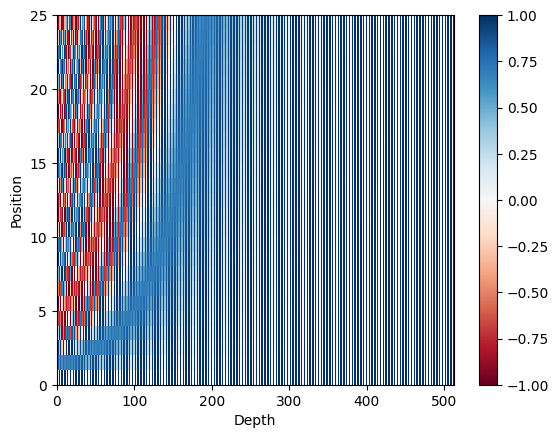

In [5]:
# PositionalEncoding 시각화
sample_pos_encoding = PositionalEncoding(25, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [6]:
# gpt-1 학습 가능한 위치 임베딩
class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)

    def forward(self, x):
        # x: (batch_size, seq_len)
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        return self.pos_embedding(positions)

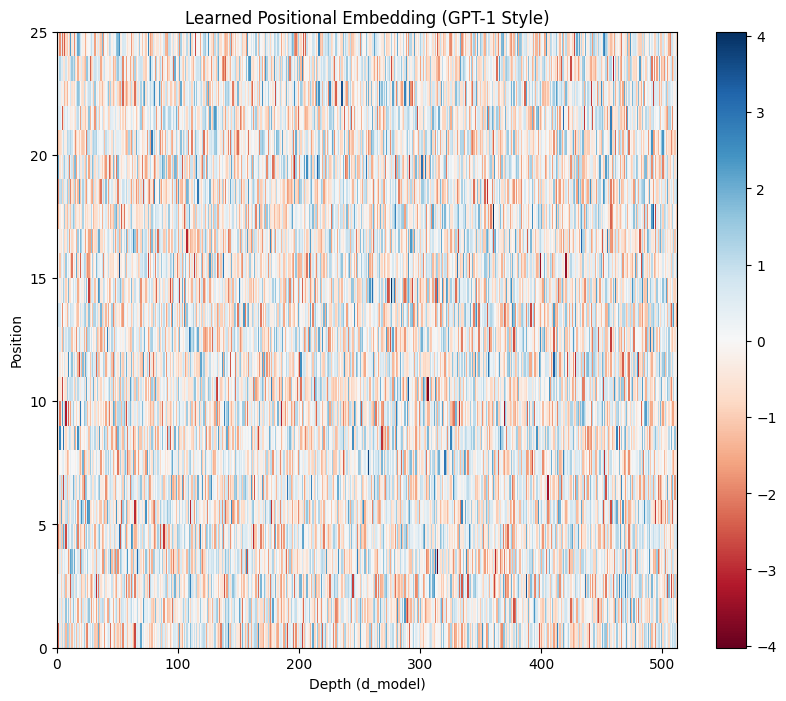

In [7]:
sample_pos_embedding = LearnedPositionalEmbedding(25, 512)

# 시각화 코드 수정
pos_weights = sample_pos_embedding.pos_embedding.weight.detach().cpu().numpy()

plt.figure(figsize=(10, 8))
plt.pcolormesh(pos_weights, cmap='RdBu') # [Position, Depth] 크기의 행렬 시각화
plt.xlabel('Depth (d_model)')
plt.ylabel('Position')
plt.title('Learned Positional Embedding (GPT-1 Style)')
plt.colorbar()
plt.show()

---
#### scaled dot product

In [8]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

#### Multi Head Attention

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


---
#### Mask Generator

In [10]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [11]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

---
### Transformer 모델 정의

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [13]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [15]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

In [16]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [17]:
def test_transformer_inference(model, vocab_size, device):
    model.eval()
    
    # image_3e08fe.png에 표시된 크기에 맞춰 가짜 데이터 생성
    # 인코더 입력: (batch_size, src_seq_len) -> [32, 25]
    enc_input = torch.randint(0, vocab_size, (32, 25)).to(device)
    # 디코더 입력: (batch_size, tgt_seq_len) -> [32, 24]
    dec_input = torch.randint(0, vocab_size, (32, 24)).to(device)

    with torch.no_grad():
        # [중요] 인자를 2개 전달해야 합니다.
        output = model(enc_input, dec_input)
        
    print(f"--- Transformer (Before) 테스트 ---")
    print(f"인코더 입력 크기: {enc_input.shape}") # [32, 25]
    print(f"디코더 입력 크기: {dec_input.shape}") # [32, 24]
    print(f"최종 출력 크기: {output.shape}")      # [32, 24, vocab_size]
    
    if output.shape == (32, 24, vocab_size):
        print("정상 작동: 기존 Transformer 구조에서 로짓이 생성되었습니다.")

---
### GPT-1 모델 정의

In [18]:
# DecoderLayer 변형 GPTBlock > EncoderLayer 구조 동일
class GPTBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(GPTBlock, self).__init__()
        # 첫 번째 서브 레이어: 셀프 어텐션만 남김
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)

        # [변경사항] 두 번째 서브 레이어(encdec_mha)는 GPT-1에 필요 없으므로 삭제합니다.

        # 세 번째 서브 레이어: 피드포워드 네트워크
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # 1) 셀프 어텐션 (미래 토큰 마스킹 적용)
        attn_out = self.self_mha(x, x, x, mask=mask)
        attn_out = self.dropout1(attn_out)
        out1 = self.norm1(x + attn_out)  # 잔차 연결 + LayerNorm

        # 2) 피드포워드
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out)
        out2 = self.norm2(out1 + ffn_out)
        return out2

In [19]:
class GPT1(nn.Module):
    def __init__(self, vocab_size, d_model=768, num_layers=12, num_heads=12, ff_dim=3072, 
                 max_len=512, num_classes=None, dropout=0.1):
        super().__init__()
        # 학습 가능한 위치 정보 추가
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = LearnedPositionalEmbedding(max_len, d_model) 
        
        # 디코더 블록 적층
        self.blocks = nn.ModuleList([
            GPTBlock(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
      
        # 사전 학습용 헤드 (L1)
        self.lm_head = nn.Linear(d_model, vocab_size)
        
        # 특정 태스크 분류용 출력층 (L2: 지도 학습용)
        self.task_head = None
        if num_classes is not None:
            self.task_head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        mask = create_look_ahead_mask(x)
        h = self.token_emb(x) + self.pos_emb(x)
        
        for block in self.blocks:
            h = block(h, mask)
            
        # L1용 결과는 항상 계산 (사전 학습 지식 유지용)
        lm_logits = self.lm_head(h) 
        
        if self.task_head is not None:
            # L2용 결과 (마지막 토큰 위치의 값)
            task_logits = self.task_head(h[:, -1, :])
            # 둘 다 반환하여 L3 계산이 가능하게 함
            return lm_logits, task_logits
        
        return lm_logits

In [20]:
# 입력에 따른 출력 로짓 생성 확인
def test_gpt_inference(model, vocab_size, device):   
    model.eval()
    
    # 가짜 데이터 생성
    dummy_input = torch.randint(0, vocab_size, (1, 10)) # (batch_size, seq_len)
    
    # 입력 데이터를 모델과 동일한 장치로 이동시킵니다.
    dummy_input = dummy_input.to(device)
    
    with torch.no_grad():
        output = model(dummy_input)
        
    print(f"현재 사용 장치: {device}")
    print(f"입력 크기: {dummy_input.shape}") # (1, 10)
    print(f"출력 크기: {output.shape}")      # (1, 10, vocab_size)
    
    if output.shape == (1, 10, vocab_size):
        print("정상 작동: 다음 단어 예측을 위한 로짓이 성공적으로 생성되었습니다.")

---
#### Model Trainer

In [21]:
def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)|
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [22]:
def train_step(model, batch, optimizer, loss_function, device, pad_id):
    model.train()
    
    # 1. 일단 모든 데이터를 디바이스로 보냅니다.
    batch = [x.to(device) for x in batch]
    optimizer.zero_grad()

    # 2. 배치 안의 데이터 개수로 모델 타입을 판별합니다.
    if len(batch) == 3:
        # [Transformer용] enc_input, dec_input, target 순서
        enc_input, dec_input, target = batch
        logits = model(enc_input, dec_input)
    else:
        # [GPT-1용] inputs, targets 순서
        inputs, target = batch
        logits = model(inputs)

    # 3. Loss 및 역전파 (공통)
    loss = loss_function(logits.permute(0, 2, 1), target)
    loss.backward()
    optimizer.step()

    # 4. 정확도 계산 (공통)
    acc = accuracy_function(logits, target, pad_id=pad_id)
    return loss.item(), acc

In [23]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device, pad_id, save_path="checkpoints"):
    model.to(device)
    
    # 1. 저장 디렉토리 생성
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device, pad_id)
            total_loss += loss
            total_acc += acc

            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")
        
        # --- 2. 20 에포크마다 체크포인트 저장 ---
        if (epoch + 1) % 10 == 0 or (epoch + 1 == num_epochs) :
            checkpoint_file = os.path.join(save_path, f"checkpoint_epoch_{epoch+1}.pt")
            
            # 모델 가중치, 옵티마이저, 스케줄러 상태를 모두 저장 (재개 가능하도록)
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
            }, checkpoint_file)
            
            print(f"==> Checkpoint saved: {checkpoint_file}")


---
#### Data Management Module

In [24]:
def analyze_and_plot(df, columns, limit_len=25):
    """
    텍스트 데이터의 길이 통계, 특정 길이 포함 비율 확인 및 시각화를 수행합니다.
    """
    plt.figure(figsize=(12, 5))
    
    for i, col in enumerate(columns):
        # 1. 길이 계산
        lengths = df[col].apply(len)
        
        # 2. 통계치 산출
        mean_val = lengths.mean()
        median_val = lengths.median()
        max_val = lengths.max()
        
        # 3. 포함 비율 계산 (평균 기준 & 사용자 입력 기준)
        mean_coverage = (lengths <= mean_val).sum() / len(lengths) * 100
        limit_coverage = (lengths <= limit_len).sum() / len(lengths) * 100
        
        # 4. 텍스트 통계 출력
        print(f"[{col} 데이터 통계]")
        print(f" - 평균: {mean_val:.2f} / 중앙값: {median_val} / 최대: {max_val}")
        print(f" - 평균({mean_val:.2f}) 이하 포함 비율: {mean_coverage:.2f}%")
        print(f" - 설정 길이({limit_len}) 이하 포함 비율: {limit_coverage:.2f}%")
        print("-" * 40)
        
        # 5. 히스토그램 시각화
        plt.subplot(1, len(columns), i + 1)
        plt.hist(lengths, bins=30, alpha=0.7, color='skyblue' if i==0 else 'salmon')
        plt.axvline(limit_len, color='red', linestyle='--', label=f'Limit ({limit_len})')
        plt.title(f'{col} Length Distribution')
        plt.xlabel('Length')
        plt.ylabel('Count')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [196]:
def preprocess_sentence(sentence):
    sentence = str(sentence) if sentence is not None else ""
    # 1. 양쪽 공백 제거
    sentence = sentence.strip()

    # 2. 단어와 구두점(?.!,) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 3. 한글(가-힣, ㄱ-ㅎ, ㅏ-ㅣ)과 구두점(?.!,)을 제외한 모든 문자를 공백으로 대체
    # 영어도 함께 남기고 싶다면 a-zA-Z를 추가하세요.
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence)
    
    # 4. 다시 양쪽 공백 제거 및 불필요한 공백 정리
    sentence = sentence.strip()
    return sentence

In [26]:
class CornellDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

In [27]:
class GPTDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.sp = tokenizer
        self.max_len = max_len
        self.pad_id = self.sp.pad_id()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # 1. 텍스트 추출 및 강제 문자열 변환 (에러 방지)
        text = str(self.texts[idx])
        
        # 2. 토큰화
        # 필요에 따라 문장 앞뒤에 BOS/EOS 토큰 ID를 수동으로 추가할 수 있습니다.
        tokens = self.sp.encode_as_ids(text)
        
        # 3. 최대 길이에 맞게 자르기 및 패딩 처리
        tokens = tokens[:self.max_len]
        padding_len = self.max_len - len(tokens)
        tokens = tokens + ([self.pad_id] * padding_len)
        
        # 4. 입력(x)과 정답(y) 생성 (Next Token Prediction을 위한 Shifting)
        # 입력을 한 토큰씩 밀어서 모델이 다음 단어를 예측하게 만듭니다.
        # 예: [A, B, C, D] -> input: [A, B, C], target: [B, C, D]
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)
        
        return x, y

#### Data Loading

In [28]:
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')

    # 구조 확인 (Q, A, label 컬럼이 있는지 확인)
    expected_columns = ['Q', 'A', 'label']
    if all(col in df.columns for col in expected_columns):
        print("데이터 로드 성공: 지정된 컬럼(Q, A, label)을 모두 포함하고 있습니다.")
    else:
        print(f"주의: 컬럼 구성이 다릅니다. 현재 컬럼: {list(df.columns)}")

    # 데이터 샘플 확인
    print(df.head())

except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
except Exception as e:
    print(f"오류 발생: {e}")

데이터 로드 성공: 지정된 컬럼(Q, A, label)을 모두 포함하고 있습니다.
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [29]:
# 글자 한 개인 행 제거
df = df[df.apply(lambda row: len(str(row['Q'])) > 1 and len(str(row['A'])) > 1, axis=1)]
df = df.reset_index(drop=True)

# 데이터 전처리
df['Q'] = df['Q'].apply(preprocess_sentence)
df['A'] = df['A'].apply(preprocess_sentence)

questions = df['Q'].tolist()
answers = df['A'].tolist()
pairs = list(zip(questions, answers))

print('전체 샘플 수 :', len(questions))
print('전처리 후 Q 샘플 :', questions[0])
print('전처리 후 A 샘플 :', answers[0])

전체 샘플 수 : 11812
전처리 후 Q 샘플 : 12시 땡 !
전처리 후 A 샘플 : 하루가 또 가네요 .


---
#### Tokenizer Trainer

In [30]:
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [31]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix=sp_model_name,
    vocab_size=VOCAB_SIZE,
    character_coverage=0.9995,
    model_type="unigram",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus.txt
  input_format: 
  model_prefix: spm_uni_cornell_5000
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_p

In [32]:
sp = spm.SentencePieceProcessor()
sp.load(f'{sp_model_name}.model')

True

---
### GPT-1

---
#### Tokenizer Trainer

GPT-1 전용 데이터 QA 결합  
- QA 결합: 질문과 답변을 <SEP> 구분자로 통합하여 단일 시퀀스 구성.  
- 데이터 시프트: Next Token Prediction을 위한 Input/Target 생성 (Causal LM).  
- 안정성 확보: 결측치 및 데이터 타입 에러 방지를 위한 문자열 강제 변환.

In [33]:
df['combined'] = df['Q'].astype(str) + " <SEP> " + df['A'].astype(str)
print(df['combined'].iloc[0])

12시 땡 ! <SEP> 하루가 또 가네요 .


In [34]:
gpt_dataset = GPTDataset(df['combined'].tolist(), sp, MAX_LEN)

In [35]:
train_dataloader = DataLoader(gpt_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
# 검증: 첫 번째 배치의 형태 확인
for inputs, targets in train_dataloader:
    print(f"Input Shape: {inputs.shape}")   # [32, 63]
    print(f"Target Shape: {targets.shape}") # [32, 63]
    
    # 0번 인덱스의 입력과 타겟 관계 출력
    # Input의 2번째 토큰이 Target의 1번째 토큰과 같아야 함
    print(f"Input[0, 1]: {inputs[0, 1].item()}")
    print(f"Target[0, 0]: {targets[0, 0].item()}")
    break

Input Shape: torch.Size([32, 63])
Target Shape: torch.Size([32, 63])
Input[0, 1]: 59
Target[0, 0]: 59


---
#### LRScheduler

In [37]:
# Noam Scheduler
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

In [38]:
# 하이퍼파라미터 설정
TOTAL_STEPS = len(train_dataloader) * EPOCH
WARMUP_STEPS  = int(TOTAL_STEPS * 0.1)

In [39]:
# Linear Warmup lr
noam_lr = lr * math.sqrt(D_MODEL) * math.sqrt(WARMUP_STEPS)

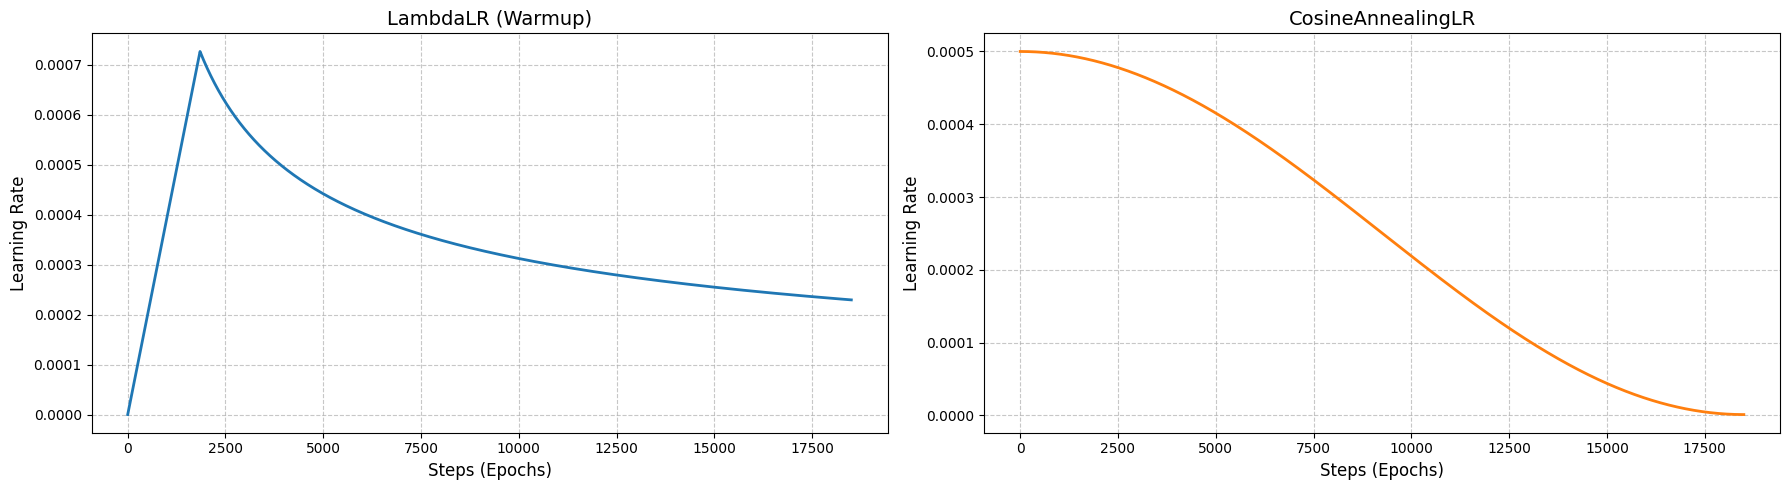

In [40]:
# 스케줄러 시각화
def get_lr_history(scheduler, optimizer, total_steps):
    history = []
    for _ in range(total_steps):
        history.append(optimizer.param_groups[0]['lr'])
        # 실제 학습 시에는 optimizer.step()이 먼저 호출됨
        optimizer.step()
        scheduler.step()
    return history

# 2. 각 케이스별 시뮬레이션
# Case 1: LambdaLR (Custom Warmup)
model_1 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_1 = optim.Adam(model_1.parameters(), lr = 0.5, betas=(0.9, 0.98), weight_decay=0.01)
sched_1 = torch.optim.lr_scheduler.LambdaLR(opt_1, lr_lambda=get_lr_lambda(D_MODEL, WARMUP_STEPS))
hist_1 = get_lr_history(sched_1, opt_1, TOTAL_STEPS)

# Case 2: CosineAnnealingLR
model_2 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_2 = optim.AdamW(model_2.parameters(), lr=lr)
sched_2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt_2, T_max=TOTAL_STEPS, eta_min=1e-6)
hist_2 = get_lr_history(sched_2, opt_2, TOTAL_STEPS)

# 3. 가로로 3개 출력 (시각화)
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
titles = ['LambdaLR (Warmup)', 'CosineAnnealingLR']
histories = [hist_1, hist_2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, ax in enumerate(axes):
    ax.plot(range(TOTAL_STEPS), histories[i], color=colors[i], linewidth=2)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Steps (Epochs)', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)
    # ax.set_yscale('log')
    # ax.set_ylim(1e-9, 2e-3)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---
#### GPT-1 Model Setup

In [ ]:
# summary용 모델 생성
test_gpt_model = GPT1(
    vocab_size=10000,
    num_layers=12,
    ff_dim=3072,
    d_model=768,
    num_heads=12,
    max_len=512,
    dropout=0.1
).to(device)

In [42]:
summary(
    test_gpt_model, 
    input_size=(BATCH_SIZE, MAX_LEN),
    dtypes=[torch.long],     
    device=device            
)

Layer (type:depth-idx)                   Output Shape              Param #
GPT1                                     [32, 64, 10000]           --
├─Embedding: 1-1                         [32, 64, 768]             7,680,000
├─LearnedPositionalEmbedding: 1-2        [1, 64, 768]              --
│    └─Embedding: 2-1                    [1, 64, 768]              393,216
├─ModuleList: 1-3                        --                        --
│    └─GPTBlock: 2-2                     [32, 64, 768]             --
│    │    └─MultiHeadAttention: 3-1      [32, 64, 768]             2,362,368
│    │    └─Dropout: 3-2                 [32, 64, 768]             --
│    │    └─LayerNorm: 3-3               [32, 64, 768]             1,536
│    │    └─Sequential: 3-4              [32, 64, 768]             4,722,432
│    │    └─Dropout: 3-5                 [32, 64, 768]             --
│    │    └─LayerNorm: 3-6               [32, 64, 768]             1,536
│    └─GPTBlock: 2-3                     [32, 64, 768

In [43]:
test_gpt_inference(test_gpt_model, 10000, device)

현재 사용 장치: cuda
입력 크기: torch.Size([1, 10])
출력 크기: torch.Size([1, 10, 10000])
정상 작동: 다음 단어 예측을 위한 로짓이 성공적으로 생성되었습니다.


In [44]:
# 학습용 모델 생성
gpt_model = GPT1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    ff_dim=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    max_len=MAX_LEN,
    dropout=DROPOUT
).to(device)

---
#### Optimization Strategy

In [45]:
# # AdamW + 선형 워밍업
# optimizer = optim.AdamW(gpt_model.parameters(), lr = noam_lr, betas=(0.9, 0.999), weight_decay=0.01)
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=WARMUP_STEPS))

In [46]:
# AdamW + 코사인 어닐링
optimizer = optim.AdamW(gpt_model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TOTAL_STEPS)

---
#### Model Training Loop

In [47]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [48]:
%%time
train(
    model=gpt_model,
    dataloader= train_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=EPOCH,  # 원하는 에폭 수
    device=device,
    save_path="checkpoints_gpt",
    pad_id=sp.pad_id()
)

[Epoch 1, Step 0] Loss: 8.7248, Acc: 0.0018
[Epoch 1, Step 100] Loss: 4.3427, Acc: 0.4122
[Epoch 1, Step 200] Loss: 4.0160, Acc: 0.4419
[Epoch 1, Step 300] Loss: 4.0117, Acc: 0.4269
Epoch 1 Completed - Avg Loss: 4.3565, Avg Acc: 0.4059
[Epoch 2, Step 0] Loss: 3.5913, Acc: 0.4718
[Epoch 2, Step 100] Loss: 3.6218, Acc: 0.4523
[Epoch 2, Step 200] Loss: 3.5225, Acc: 0.4552
[Epoch 2, Step 300] Loss: 3.5573, Acc: 0.4675
Epoch 2 Completed - Avg Loss: 3.5965, Avg Acc: 0.4570
[Epoch 3, Step 0] Loss: 3.1541, Acc: 0.4816
[Epoch 3, Step 100] Loss: 3.0602, Acc: 0.4819
[Epoch 3, Step 200] Loss: 3.2622, Acc: 0.4694
[Epoch 3, Step 300] Loss: 2.9903, Acc: 0.5045
Epoch 3 Completed - Avg Loss: 3.1226, Avg Acc: 0.4865
[Epoch 4, Step 0] Loss: 2.7610, Acc: 0.5210
[Epoch 4, Step 100] Loss: 2.6561, Acc: 0.5240
[Epoch 4, Step 200] Loss: 2.7256, Acc: 0.5431
[Epoch 4, Step 300] Loss: 2.7997, Acc: 0.4952
Epoch 4 Completed - Avg Loss: 2.7363, Avg Acc: 0.5176
[Epoch 5, Step 0] Loss: 2.3271, Acc: 0.5482
[Epoch 5, St

---
### Transformer

---
#### DataModule

[Q 데이터 통계]
 - 평균: 13.24 / 중앙값: 12.0 / 최대: 57
 - 평균(13.24) 이하 포함 비율: 60.44%
 - 설정 길이(25) 이하 포함 비율: 94.96%
----------------------------------------
[A 데이터 통계]
 - 평균: 16.05 / 중앙값: 15.0 / 최대: 78
 - 평균(16.05) 이하 포함 비율: 60.94%
 - 설정 길이(25) 이하 포함 비율: 92.08%
----------------------------------------


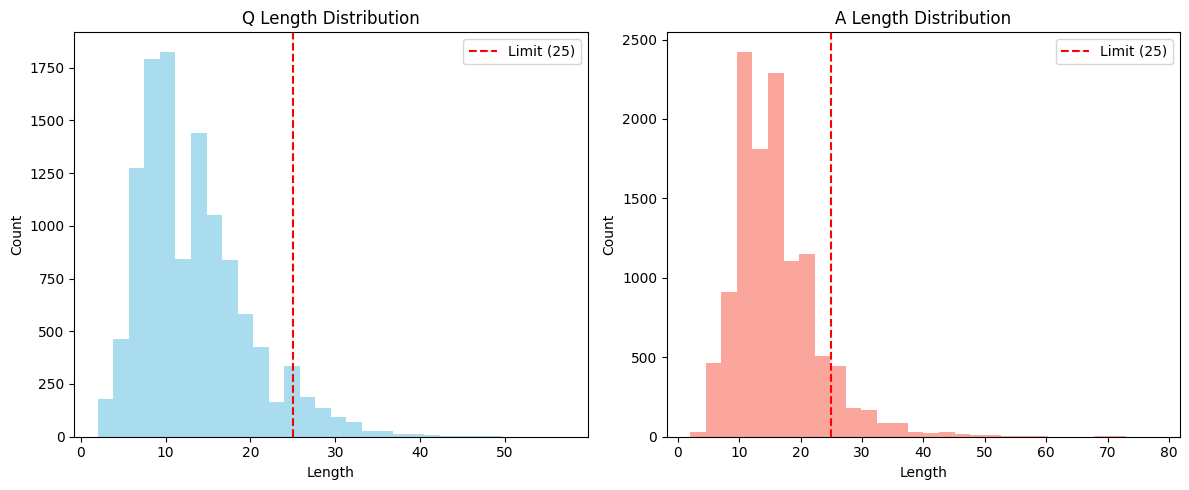

In [49]:
analyze_and_plot(df, columns=['Q', 'A'], limit_len=LIMIT_LEN)

In [50]:
dataset = CornellDataset(pairs, sp, max_length=LIMIT_LEN)

In [51]:
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([25])
tensor([   1, 4168,  282,    5, 4786,   52,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
12시 땡 !
tensor([  1, 279,   7, 112, 102,  26,   4,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
하루가 또 가네요 .
tensor([279,   7, 112, 102,  26,   4,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
하루가 또 가네요 .


 DataLoader 구성하기

In [52]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)

In [53]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 25])
torch.Size([32, 24])
torch.Size([32, 24])


---
#### LRScheduler

In [54]:
# Noam Scheduler
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

In [55]:
# 하이퍼파라미터 설정
TOTAL_STEPS = len(dataloader) * EPOCH
WARMUP_STEPS  = int(TOTAL_STEPS * 0.1)

In [56]:
# Linear Warmup lr
noam_lr = lr * math.sqrt(D_MODEL) * math.sqrt(WARMUP_STEPS)

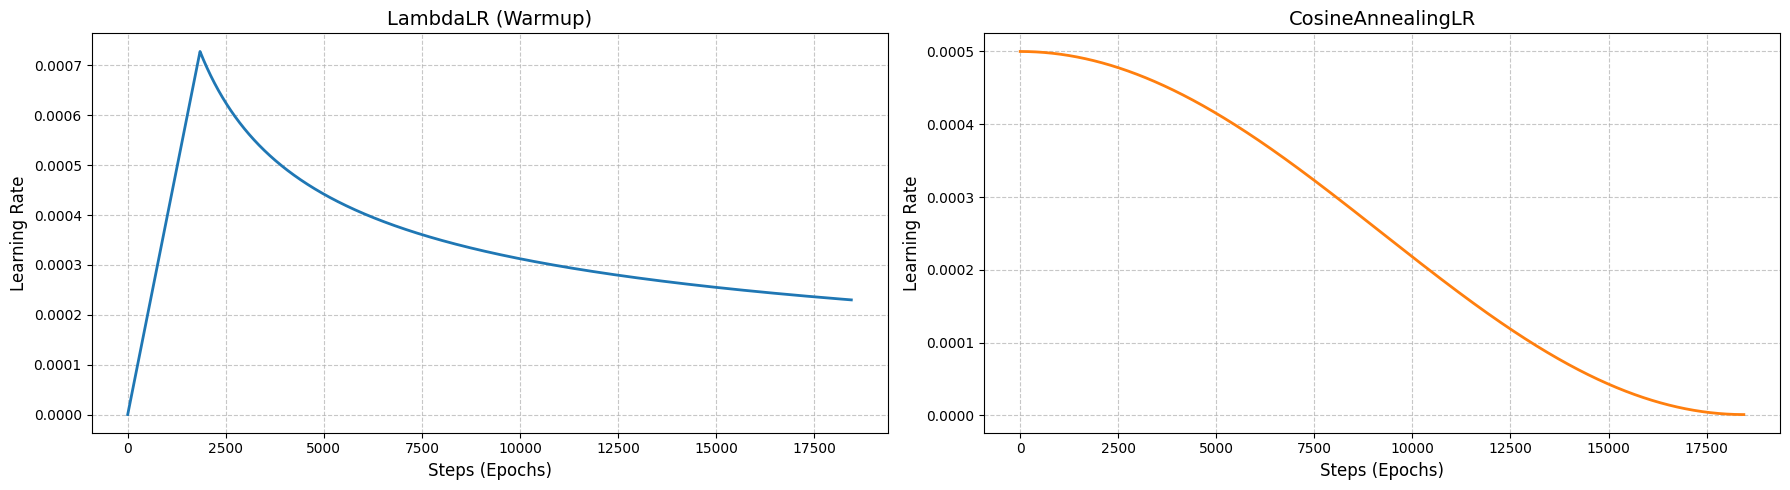

In [57]:
# 스케줄러 시각화
def get_lr_history(scheduler, optimizer, total_steps):
    history = []
    for _ in range(total_steps):
        history.append(optimizer.param_groups[0]['lr'])
        # 실제 학습 시에는 optimizer.step()이 먼저 호출됨
        optimizer.step()
        scheduler.step()
    return history

# 2. 각 케이스별 시뮬레이션
# Case 1: LambdaLR (Custom Warmup)
model_1 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_1 = optim.Adam(model_1.parameters(), lr = 0.5, betas=(0.9, 0.98), weight_decay=0.01)
sched_1 = torch.optim.lr_scheduler.LambdaLR(opt_1, lr_lambda=get_lr_lambda(D_MODEL, WARMUP_STEPS))
hist_1 = get_lr_history(sched_1, opt_1, TOTAL_STEPS)

# Case 2: CosineAnnealingLR
model_2 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_2 = optim.AdamW(model_2.parameters(), lr=lr)
sched_2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt_2, T_max=TOTAL_STEPS, eta_min=1e-6)
hist_2 = get_lr_history(sched_2, opt_2, TOTAL_STEPS)

# 3. 가로로 3개 출력 (시각화)
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
titles = ['LambdaLR (Warmup)', 'CosineAnnealingLR']
histories = [hist_1, hist_2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, ax in enumerate(axes):
    ax.plot(range(TOTAL_STEPS), histories[i], color=colors[i], linewidth=2)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Steps (Epochs)', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)
    # ax.set_yscale('log')
    # ax.set_ylim(1e-9, 2e-3)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---
#### Transformer Model Setup

In [ ]:
# summary용 모델 생성
test_trans_model = Transformer(
    vocab_size=10000,
    num_layers=12,
    units=3072,
    d_model=768,
    num_heads=12,
    dropout=0.1
).to(device)

In [59]:
summary(
    test_trans_model, 
    input_size=[(32, 25), (32, 24)], # [encoder_input 크기, decoder_input 크기]
    dtypes=[torch.long, torch.long], # 두 입력 모두 정수형 토큰
    device=device
)

Layer (type:depth-idx)                             Output Shape              Param #
Transformer                                        [32, 24, 10000]           --
├─Encoder: 1-1                                     [32, 25, 768]             --
│    └─Embedding: 2-1                              [32, 25, 768]             7,680,000
│    └─PositionalEncoding: 2-2                     [32, 25, 768]             --
│    └─Dropout: 2-3                                [32, 25, 768]             --
│    └─ModuleList: 2-4                             --                        --
│    │    └─EncoderLayer: 3-1                      [32, 25, 768]             7,087,872
│    │    └─EncoderLayer: 3-2                      [32, 25, 768]             7,087,872
│    │    └─EncoderLayer: 3-3                      [32, 25, 768]             7,087,872
│    │    └─EncoderLayer: 3-4                      [32, 25, 768]             7,087,872
│    │    └─EncoderLayer: 3-5                      [32, 25, 768]             7,0

In [60]:
test_transformer_inference(test_trans_model, VOCAB_SIZE, device)

--- Transformer (Before) 테스트 ---
인코더 입력 크기: torch.Size([32, 25])
디코더 입력 크기: torch.Size([32, 24])
최종 출력 크기: torch.Size([32, 24, 10000])


In [ ]:
# 학습용 모델 생성
trans_model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
).to(device)

---
#### Optimization Strategy

In [62]:
# # AdamW + 선형 워밍업
# optimizer = optim.AdamW(trans_model.parameters(), lr = noam_lr, betas=(0.9, 0.999), weight_decay=0.01)
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=WARMUP_STEPS))

In [63]:
# AdamW + 코사인 어닐링
optimizer = optim.AdamW(trans_model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TOTAL_STEPS)

---
#### Model Training Loop

In [64]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [65]:
%%time
train(
    model=trans_model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=EPOCH, 
    device=device,
    save_path="checkpoints_trans",
    pad_id=sp.pad_id()
)

[Epoch 1, Step 0] Loss: 8.6204, Acc: 0.0000
[Epoch 1, Step 100] Loss: 5.2557, Acc: 0.2825
[Epoch 1, Step 200] Loss: 4.5790, Acc: 0.3118
[Epoch 1, Step 300] Loss: 4.7020, Acc: 0.3307
Epoch 1 Completed - Avg Loss: 4.9150, Avg Acc: 0.3095
[Epoch 2, Step 0] Loss: 4.0111, Acc: 0.3705
[Epoch 2, Step 100] Loss: 3.8415, Acc: 0.3953
[Epoch 2, Step 200] Loss: 4.2140, Acc: 0.3344
[Epoch 2, Step 300] Loss: 4.0091, Acc: 0.3482
Epoch 2 Completed - Avg Loss: 3.8870, Avg Acc: 0.3863
[Epoch 3, Step 0] Loss: 3.3535, Acc: 0.4355
[Epoch 3, Step 100] Loss: 3.0358, Acc: 0.4879
[Epoch 3, Step 200] Loss: 3.4088, Acc: 0.4375
[Epoch 3, Step 300] Loss: 3.5373, Acc: 0.3806
Epoch 3 Completed - Avg Loss: 3.3198, Avg Acc: 0.4369
[Epoch 4, Step 0] Loss: 3.0641, Acc: 0.4500
[Epoch 4, Step 100] Loss: 3.0084, Acc: 0.4727
[Epoch 4, Step 200] Loss: 2.8299, Acc: 0.5273
[Epoch 4, Step 300] Loss: 2.7399, Acc: 0.4942
Epoch 4 Completed - Avg Loss: 2.8738, Avg Acc: 0.4857
[Epoch 5, Step 0] Loss: 2.3098, Acc: 0.5647
[Epoch 5, St

---
#### Chat Test

In [ ]:
import torch
import sentencepiece as spm

In [238]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    sentence = preprocess_sentence(str(sentence))
    if not sentence.strip(): sentence = " "

    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    
    # SentencePiece 전용 토큰 확인 로직
    sep_id = tokenizer.piece_to_id('<SEP>')
    SEP_TOKEN = sep_id if sep_id != tokenizer.unk_id() else START_TOKEN

    q_tokens = tokenizer.encode(sentence)

    model.eval()
    if model.__class__.__name__ == 'GPT1':
        MAX_LENGTH = 20
        # 1. 리스트로 먼저 만듭니다.
        input_ids_list = [START_TOKEN] + q_tokens + [SEP_TOKEN]
        
        # list는 .size()가 없으므로 len()을 사용합니다.
        prompt_len = len(input_ids_list) 
        
        # 2. 이후 텐서로 변환합니다.
        curr_input = torch.tensor([input_ids_list], dtype=torch.long, device=device)
        enc_input = None
    else:
        MAX_LENGTH = 40
        # Transformer 방식
        enc_input_ids = [START_TOKEN] + q_tokens + [END_TOKEN]
        enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)
        curr_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)
        prompt_len = 0

    with torch.no_grad():
        for i in range(MAX_LENGTH):
            if model.__class__.__name__ == 'GPT1':
                logits = model(curr_input)
            else:
                logits = model(enc_input, curr_input)

            predicted_id = torch.argmax(logits[:, -1, :], dim=-1)
            if predicted_id.item() == END_TOKEN:
                break
            curr_input = torch.cat([curr_input, predicted_id.unsqueeze(0)], dim=1)

    result_ids = curr_input.squeeze(0).tolist()
    # prompt_len 만큼 잘라서 반환
    return result_ids[prompt_len:] if model.__class__.__name__ == 'GPT1' else result_ids

In [239]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [240]:
sentences = [
    '안녕',
    '너 괜찮아?',
    '오늘 기분이 어때?',
    '배고픈데 뭐 먹을까?',
    '공부하기 너무 싫다',
    "요즘 살이 찐 거 같은데 운동이나 해볼까?",
    "요즘 살이 찐 거 같은데",
    '바보야',
    '멍청아',
    "너는 누구야?",
    "사랑해",
    "친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어"
]

In [241]:
def sentence_output(test_model, spm, device):
    while True:
        sentence = input("문장을 입력해주세요 (테스트: 1, 종료: q): ").strip()

        
        # 1. 종료 조건
        if sentence.lower() == 'q':
            print("\n프로그램을 종료합니다.")
            break
        
        # 2. 배치 테스트 모드
        if sentence == "1":
            print(" 챗봇 테스트 시작 ".center(30, "="))
            # 변수명이 겹치지 않게 s로 변경 (기존 sentence 보존)
            for s in sentences:
                print(f"Q: {s}")
                answer = sentence_generation(test_model, s, spm, device)
                print("-" * 20)
            print(" 테스트 완료 ".center(30, "="))
            # 테스트가 끝났으니 다시 루프 처음으로 돌아감
            continue 

        # 3. 일반 입력 모드 (아무것도 입력 안 했을 때 대비)
        elif sentence:
            answer = sentence_generation(test_model, sentence, spm, device)
            print()
        
        else:
            print("내용을 입력해주세요.")

In [242]:
sp_model_name = f"spm_uni_cornell_{VOCAB_SIZE}.model"
sp = spm.SentencePieceProcessor()
sp.load(sp_model_name)

True

---
gpt

In [243]:
gpt_model = GPT1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    ff_dim=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    max_len=MAX_LEN,
    dropout=DROPOUT
).to(device)

In [244]:
checkpoint_path =f'./checkpoints_gpt/checkpoint_epoch_{EPOCH}.pt'
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_34091/4215438912.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [245]:
gpt_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [246]:
sentence_output(gpt_model, sp, device)

========= 챗봇 테스트 시작 ==========
Q: 안녕
입력 : 안녕
출력 : 할까  ⁇ S ⁇ P ⁇  너무 미워하지 마세요 . 야경구경 가세요 . 친구들을 내세요 .
--------------------
Q: 너 괜찮아?
입력 : 너 괜찮아?
출력 : 에게 물어거야  ⁇ S ⁇ P ⁇  아니에요 . 아니에요 . 제가 곁에 있을게 힘들지
--------------------
Q: 오늘 기분이 어때?
입력 : 오늘 기분이 어때?
출력 : 냐  ⁇ S ⁇ P ⁇  맛있게 드세요 . 그렇지만 원망해주세요 . 기억될까봐 부드
--------------------
Q: 배고픈데 뭐 먹을까?
입력 : 배고픈데 뭐 먹을까?
출력 : 러가 좋을까 ?  ⁇ S ⁇ P ⁇  절대 아니에요 . 안부인 것 같아요 . 이번
--------------------
Q: 공부하기 너무 싫다
입력 : 공부하기 너무 싫다
출력 : 나와  ⁇ S ⁇ P ⁇  꾸준한 자기 관리 좋아요 . 본인의 좋은 사람이 나타날 거예요 .
--------------------
Q: 요즘 살이 찐 거 같은데 운동이나 해볼까?
입력 : 요즘 살이 찐 거 같은데 운동이나 해볼까?
출력 : 해도  ⁇ S ⁇ P ⁇  최대한 예의가 없네요 . 자신을 더 커지거나
--------------------
Q: 요즘 살이 찐 거 같은데
입력 : 요즘 살이 찐 거 같은데
출력 : 힘드네  ⁇ S ⁇ P ⁇  감정은 숨한 만큼 아픈거라 생각해요 .  ⁇ P
--------------------
Q: 바보야
입력 : 바보야
출력 : 어떻게 해 ?  ⁇ S ⁇ P ⁇  척 하는 편이 좋겠어요 . 그렇다면 것도 아니
--------------------
Q: 멍청아
입력 : 멍청아
출력 : 힘드네  ⁇ S ⁇ P ⁇  사랑의 예의가 없네요 . 수록 외부적이 됩니다
--------------------
Q: 너는 누구야?
입력 : 너는 누구야?
출력 : 냐 ?  ⁇ S ⁇ P ⁇  사람마다 다를 거예요 . 미련 정도는 자책

---
Transformer

In [247]:
trans_model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
).to(device)

In [248]:
checkpoint_path =f'./checkpoints_trans/checkpoint_epoch_{EPOCH}.pt'
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_34091/1566187099.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [249]:
trans_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [250]:
sentence_output(trans_model, sp, device)

========= 챗봇 테스트 시작 ==========
Q: 안녕
입력 : 안녕
출력 : 안녕하세요 .
--------------------
Q: 너 괜찮아?
입력 : 너 괜찮아?
출력 : 저는 마음을 이어주는 위로봇입니다 .
--------------------
Q: 오늘 기분이 어때?
입력 : 오늘 기분이 어때?
출력 : 맛이 없든 있든 좋을 것 같아요 .
--------------------
Q: 배고픈데 뭐 먹을까?
입력 : 배고픈데 뭐 먹을까?
출력 : 좀 먹어도 괜찮아요 .
--------------------
Q: 공부하기 너무 싫다
입력 : 공부하기 너무 싫다
출력 : 잠시 쉬어도 돼요 .
--------------------
Q: 요즘 살이 찐 거 같은데 운동이나 해볼까?
입력 : 요즘 살이 찐 거 같은데 운동이나 해볼까?
출력 : 식이요법이랑 같이 병행해보세요 .
--------------------
Q: 요즘 살이 찐 거 같은데
입력 : 요즘 살이 찐 거 같은데
출력 : 연인은 살쪄도 잘 알아차리지 못하고 알아차려도 싫어하지 않을 거예요 .
--------------------
Q: 바보야
입력 : 바보야
출력 : 좋은 말만 해주세요 .
--------------------
Q: 멍청아
입력 : 멍청아
출력 : 좋은 말만 해주세요 .
--------------------
Q: 너는 누구야?
입력 : 너는 누구야?
출력 : 저는 마음을 이어주는 위로봇입니다 .
--------------------
Q: 사랑해
입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 사랑해요 .
--------------------
Q: 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
입력 : 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
출력 : 그런 친구는 거르세요 .
--------------------
=========== 테스트 완료 ===========

프로그램을 종료합니다.
